In [2]:
# % matplotlib inline
from neuprint import Client, skeleton
from neuprint import fetch_synapses, NeuronCriteria as NC, SynapseCriteria as SC
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import importlib
import random
import pickle
import os
import seaborn as sns
from sklearn.manifold import TSNE
from os.path import isfile
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import time
import tensorstore as ts
from sklearn.decomposition import PCA
import statsmodels.api as sm
from skimage import measure, morphology
from skimage.morphology import convex_hull_image
import umap
from scipy import stats
from functools import partial
from concurrent.futures import ThreadPoolExecutor, as_completed
import json

from scipy.ndimage import gaussian_filter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.colors import LightSource
from scipy import ndimage
import plotly.graph_objects as go
import plotly.io as pio
import plotly
from time import time
import ast

pio.renderers.default = 'notebook'
plotly.offline.init_notebook_mode()

np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation
home_dir = '/Users/aatmikmallya/Desktop/research/fly/segmentation'
neuron_quality = pd.read_csv(f'{home_dir}/saved_data/neuron_quality.csv')
neuron_quality_np = neuron_quality.to_numpy()

def import_module(module_name, file_path):
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

utils = import_module('utils', f'{home_dir}/util_files/utils.py')
config = import_module('config', f'{home_dir}/util_files/config.py')
voxel_utils = import_module('voxel_utils', f'{home_dir}/util_files/voxel_utils.py')
segmentation = import_module('segmentation', f'{home_dir}/util_files/segmentation.py')
analysis = import_module('analysis', f'{home_dir}/util_files/analysis.py')

In [6]:
import numpy as np
from skimage.morphology import ball
import napari

# Generate test data
data_shape = (100, 100, 100)
segmented_data = np.zeros(data_shape, dtype=np.uint8)

centers = [(30, 30, 30), (70, 70, 70), (50, 50, 50)]
radius = 10

for center in centers:
    sphere = ball(radius)
    x, y, z = center
    r = radius
    segmented_data[
        x - r:x + r + 1,
        y - r:y + r + 1,
        z - r:z + r + 1
    ] += sphere

# Start napari viewer
viewer = napari.Viewer()
viewer.add_image(segmented_data, name='Microtubules')

# Add Points layer for centerpoints
points_layer = viewer.add_points(
    properties={'label': []},
    size=5,
    face_color='red',
    name='Centerpoints'
)

# Add Labels layer for segmentation editing
labels_layer = viewer.add_labels(segmented_data, name='Segmentation')

# If you're in Jupyter, no need for napari.run()
# Otherwise, you would add napari.run() here for standalone scripts


In [3]:
features_df = pd.read_pickle('final_features.pkl')

In [4]:
pd.read_pickle('presynapse_data.pkl').init_box_zyx.iloc[0]

array([[28612, 21587, 14441],
       [28712, 21687, 14541]])

In [71]:
prototypical_examples_df = pd.read_csv('prototypical_examples_df.csv')

In [72]:
def str_to_np_array(coord):
    if isinstance(coord, np.ndarray):
        return coord
    elif isinstance(coord, str):
        return np.array([int(x) for x in coord.strip('[]').split()])
    else:
        raise ValueError(f"Unexpected type for coord: {type(coord)}")

prototypical_examples_df['coord'] = prototypical_examples_df['coord'].apply(str_to_np_array)

In [73]:
def create_coord_array(coords):
    lower_bound = coords - 50
    upper_bound = coords + 50
    return [lower_bound, upper_bound]

prototypical_examples_df['init_box_zyx'] = prototypical_examples_df['coord'].apply(create_coord_array)


In [77]:
a,b = row.init_box_zyx

In [80]:
relax_params = {'num_iters': 25, 'delta': 0.5, 'offset': 1, 'early_stop_threshold': 0.1}
for i,row in prototypical_examples_df.iterrows():
    
    gray_subvol = voxel_utils.get_subvols_batched([row.init_box_zyx], 'grayscale')
    skel_subvol = voxel_utils.get_subvols_batched([row.init_box_zyx], 'segmentation') == row.bodyId
    mito_subvol = voxel_utils.get_subvols_batched([row.init_box_zyx], 'mito-objects') == row.bodyId
    final_seg, seg_data = segmentation.segment_synapse_batched(gray_subvol, skel_subvol, mito_subvol, row.coord, row.bodyId, row.neuron_type, i, relax_params)
    




RuntimeError: filter weights array has incorrect shape.

In [92]:
import os
import gc
import numpy as np
import pandas as pd
from time import time
import json
import shutil
from tqdm import tqdm

def get_subvols(init_boxes_zyx, vol_type):
    return voxel_utils.get_subvols_batched(init_boxes_zyx, vol_type)

def save_intermediate_results(df, gray_subvols, skel_subvols, mito_subvols, chunk_idx, tmp_dir='tmp'):
    os.makedirs(tmp_dir, exist_ok=True)
    df.to_pickle(f'{tmp_dir}/tmp_sample_df_{chunk_idx}.pkl')
    np.save(f'{tmp_dir}/tmp_gray_subvols_{chunk_idx}.npy', gray_subvols)
    np.save(f'{tmp_dir}/tmp_skel_subvols_{chunk_idx}.npy', skel_subvols)
    np.save(f'{tmp_dir}/tmp_mito_subvols_{chunk_idx}.npy', mito_subvols)

def load_intermediate_results(chunk_idx, tmp_dir='tmp'):
    df = pd.read_pickle(f'{tmp_dir}/tmp_sample_df_{chunk_idx}.pkl')
    gray_subvols = np.load(f'{tmp_dir}/tmp_gray_subvols_{chunk_idx}.npy')
    skel_subvols = np.load(f'{tmp_dir}/tmp_skel_subvols_{chunk_idx}.npy')
    mito_subvols = np.load(f'{tmp_dir}/tmp_mito_subvols_{chunk_idx}.npy')
    return df, gray_subvols, skel_subvols, mito_subvols

def save_progress(progress, filename='progress.json'):
    return
    # with open(filename, 'w') as f:
    #     json.dump(progress, f)

def load_progress(filename='progress.json'):
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            return json.load(f)
    return {'current_chunk': 0, 'processed_chunks': []}

def get_dir_size(path='.'):
    total = 0
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_file():
                total += entry.stat().st_size
            elif entry.is_dir():
                total += get_dir_size(entry.path)
    return total

def clear_old_chunks(tmp_dir='tmp', keep_last=5):
    chunks = sorted([int(f.split('_')[-1].split('.')[0]) for f in os.listdir(tmp_dir) if f.startswith('tmp_sample_df_')])
    for chunk in chunks[:-keep_last]:
        for prefix in ['tmp_sample_df_', 'tmp_gray_subvols_', 'tmp_skel_subvols_', 'tmp_mito_subvols_']:
            file_path = os.path.join(tmp_dir, f'{prefix}{chunk}.npy')
            if os.path.exists(file_path):
                os.remove(file_path)

def process_chunk(chunk_idx, sample_chunk, gray_subvols_chunk, skel_subvols_chunk, mito_subvols_chunk, relax_params):
    features_list = []
    for idx, row in tqdm(enumerate(sample_chunk.itertuples()), total=len(sample_chunk), desc=f"Processing rows in chunk {chunk_idx}", leave=False):
        result = process_row(idx, row, gray_subvols_chunk, skel_subvols_chunk, mito_subvols_chunk, relax_params)
        if result is not None:
            features_list.append(result)
    return features_list

def main(chunk_size=1000, samples_per_neuron_type=10000, max_storage_gb=256):
    progress = load_progress()
    features_list = []

    presynapse_df = prototypical_examples_df
    neuron_types = ['LC11', 'LC4', 'LC15', 'LC6', 'LC16', 'LC12', 'LC17', 'LC10']
    neuron_dfs = []
    for neuron_type in neuron_types:
        neuron_df = presynapse_df[presynapse_df.neuron_type == neuron_type]
        actual_sample_size = min(samples_per_neuron_type, len(neuron_df))
        sampled_neuron_df = neuron_df.sample(actual_sample_size, replace=False)
        neuron_dfs.append(sampled_neuron_df)

    sample_df = pd.concat(neuron_dfs).reset_index(drop=True)

    init_boxes_zyx = np.stack(sample_df.init_box_zyx.to_numpy())
    bodyIds = sample_df.bodyId.to_numpy()[:, np.newaxis, np.newaxis, np.newaxis]

    relax_params = {'num_iters': 25, 'delta': 0.5, 'offset': 1, 'early_stop_threshold': 0.1}

    total_chunks = len(sample_df) // chunk_size

    with tqdm(total=total_chunks, initial=progress['current_chunk'], desc="Processing chunks", colour='#FFC7ED') as pbar:
        for chunk_idx in range(progress['current_chunk'], total_chunks):
            if chunk_idx in progress['processed_chunks']:
                print(f"Chunk {chunk_idx} already processed. Skipping...")
                pbar.update(1)
                continue

            print(f"Processing chunk {chunk_idx}")
            start_idx = chunk_idx * chunk_size
            end_idx = (chunk_idx + 1) * chunk_size

            init_boxes_chunk = init_boxes_zyx[start_idx:end_idx]
            bodyIds_chunk = bodyIds[start_idx:end_idx]
            sample_chunk = sample_df.iloc[start_idx:end_idx]

            gray_subvols_chunk = get_subvols(init_boxes_chunk, 'grayscale')
            seg_subvols_chunk = get_subvols(init_boxes_chunk, 'segmentation')
            mito_subvols_chunk = get_subvols(init_boxes_chunk, 'mito-objects')

            skel_subvols_chunk = seg_subvols_chunk == bodyIds_chunk
            mito_subvols_chunk = mito_subvols_chunk == bodyIds_chunk

            save_intermediate_results(sample_chunk, gray_subvols_chunk, skel_subvols_chunk, mito_subvols_chunk, chunk_idx)

            chunk_features = process_chunk(chunk_idx, sample_chunk, gray_subvols_chunk, skel_subvols_chunk, mito_subvols_chunk, relax_params)
            features_list.extend(chunk_features)

            progress['current_chunk'] = chunk_idx + 1
            progress['processed_chunks'].append(chunk_idx)
            save_progress(progress)

            gc.collect()  # Explicitly call garbage collector to free up memory

            # Check if we've reached the storage limit
            if get_dir_size('tmp') > max_storage_gb * 1e9:
                print(f"Reached storage limit of {max_storage_gb}GB. Clearing old chunks.")
                clear_old_chunks()

            # Periodically save results
            if len(features_list) >= chunk_size:
                current_features_df = pd.DataFrame(features_list).dropna()
                current_features_df.to_csv(f'features_batch_{chunk_idx}.csv', index=False)
                features_list = []

            pbar.update(1)

    # Save any remaining results
    if features_list:
        final_features_df = pd.DataFrame(features_list).dropna()
        final_features_df.to_csv(f'features_batch_final.csv', index=False)

    # Combine all batch results
    all_features = pd.concat([pd.read_csv(f) for f in os.listdir('.') if f.startswith('features_batch_')])
    return all_features

def process_row(row_idx, row, gray_subvols, skel_subvols, mito_subvols, relax_params):
    try:
        final_seg, seg_data = segmentation.segment_synapse_batched(
            gray_subvols[row_idx], skel_subvols[row_idx], mito_subvols[row_idx], row.coord, row.bodyId, row.neuron_type, row_idx, relax_params
        )
        print('asdfasdf')
        segmentation.plot_3d_interactive(final_seg, seg_data)
    except Exception as e:
        if str(e).startswith('No segment'):
            return None
        else:
            raise
    features = analysis.calculate_morph_features(final_seg, gray_subvols[row_idx], skel_subvols[row_idx], mito_subvols[row_idx])
    features.update({
        'neuron_type': row.neuron_type,
        'bodyId': row.bodyId,
        'coord': row.coord
    })
    return features

if __name__ == "__main__":
    np.random.seed(0)
    start = time()
    chunk_size = 1
    samples_per_neuron_type = 1
    max_storage_gb = 256

    features_df = main(chunk_size=chunk_size, samples_per_neuron_type=samples_per_neuron_type, max_storage_gb=max_storage_gb)
    print(f"Total Processing Time: {time() - start}")

    # Save the final results
    features_df.to_pickle('test.pkl')

    # Explicitly call garbage collector to free up memory
    gc.collect()

Processing chunks:   0%|                                                                                  | 0/8 [00:00<?, ?it/s]

Processing chunk 0



Processing rows in chunk 0: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.05it/s]
                                                                                                                                

1111


Processing chunks:  12%|█████████▎                                                                | 1/8 [00:01<00:08,  1.20s/it]

Processing chunk 1



Processing rows in chunk 1:   0%|                                                                         | 0/1 [00:00<?, ?it/s]

1111



Processing chunks:  25%|██████████████████▌                                                       | 2/8 [00:02<00:07,  1.26s/it]

Processing chunk 2



Processing rows in chunk 2:   0%|                                                                         | 0/1 [00:00<?, ?it/s]

1111



Processing chunks:  38%|███████████████████████████▊                                              | 3/8 [00:03<00:06,  1.22s/it]

Processing chunk 3



Processing rows in chunk 3: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.06it/s]
                                                                                                                                

1111


Processing chunks:  50%|█████████████████████████████████████                                     | 4/8 [00:04<00:04,  1.21s/it]

Processing chunk 4



Processing rows in chunk 4: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.26it/s]
                                                                                                                                

1111


Processing chunks:  62%|██████████████████████████████████████████████▎                           | 5/8 [00:06<00:03,  1.20s/it]

Processing chunk 5



Processing rows in chunk 5: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.60it/s]
                                                                                                                                

1111


Processing chunks:  75%|███████████████████████████████████████████████████████▌                  | 6/8 [00:07<00:02,  1.17s/it]

Processing chunk 6



Processing rows in chunk 6: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.28it/s]
                                                                                                                                

1111


Processing chunks:  88%|████████████████████████████████████████████████████████████████▊         | 7/8 [00:08<00:01,  1.15s/it]

Processing chunk 7



Processing rows in chunk 7: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.67it/s]
                                                                                                                                

1111


Processing chunks: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.19s/it]


Total Processing Time: 9.53420615196228


In [18]:
with open('label/149275', 'r') as file:
    data = json.load(file)
df = pd.json_normalize(data)


In [28]:
directory = 'label'

# List to hold all dataframes
dataframes = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.isdigit():  # Ensure the filename is numeric
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as file:
            data = json.load(file)
            df = pd.json_normalize(data)
            df['bodyId'] = filename  # Add the filename as a new column
            dataframes.append(df)

# Concatenate all dataframes into a single dataframe
combined_df = pd.concat(dataframes, ignore_index=True)

# Display the combined dataframe
combined_df

Pos     Kind Tags           Prop.conf Prop.user  \
0         [13224, 33067, 27686]  PostSyn   []  0.8955339789390564             
1         [13356, 32526, 27913]  PostSyn   []  0.9500120282173157             
2         [13292, 32583, 27921]  PostSyn   []  0.7784510254859924             
3         [13356, 32442, 28140]  PostSyn   []  0.8497970104217529             
4         [13526, 32466, 28113]  PostSyn   []  0.9924290180206299             
...                         ...      ...  ...                 ...       ...   
45528302  [17951, 29325, 40371]  PostSyn   []  0.6935809850692749             
45528303  [18188, 28699, 40384]  PostSyn   []   0.957306981086731             
45528304  [18013, 29466, 40391]  PostSyn   []  0.9970970153808594             
45528305  [18086, 29521, 40445]  PostSyn   []  0.9974740147590637             
45528306  [18164, 28964, 40495]  PostSyn   []  0.9660770297050476             

          bodyId  
0         123483  
1         123483  
2         123483  
3         123483  
4         123483  
...          ...  
45528302   29739  
45528303   29739  
45528304   29739  
45528305   29739  
45528306   29739  

[45528307 rows x 6 columns]

In [ ]:
combined_df = combined_df[combined_df['Prop.conf'].astype(float) >= 0.95]
combined_df = combined_df[combined_df.Kind == 'PreSyn']
combined_df = combined_df.drop(columns=['Tags', 'Kind', 'Prop.user'])
combined_df['bodyId'] = combined_df['bodyId'].astype(int)
combined_df = combined_df.rename(columns={'Prop.conf': 'conf'})
combined_df['conf'] = combined_df['conf'].astype(float)
combined_df = combined_df.rename(columns={'Pos': 'coord'})



In [161]:
combined_df.to_pickle('optic-lobe.pkl')

In [188]:
a = combined_df.bodyId.value_counts()

In [193]:
a.head(10)

bodyId
10009    16529
10051     7688
10066     6487
10093     5862
10260     5538
10046     4773
10503     4444
10352     4232
10302     3863
10114     3564
Name: count, dtype: int64

In [183]:
combined_df.bodyId

20          123483
52          123483
67          123483
77          123483
89          123483
             ...  
45528011     29739
45528028     29739
45528204     29739
45528211     29739
45528215     29739
Name: bodyId, Length: 3041796, dtype: int64

In [2]:
def merge_dataframes_on_array(df1, df2, column='coord'):
    keep_columns = ['type', 'confidence', 'x', 'y', 'z', 'connecting_bodyId',
       'connecting_type', 'connecting_x', 'connecting_y', 'connecting_z',
       'neuron_type', 'bodyId', 'coord', 'init_box_zyx', 'volume',
       'surface_area', 'compactness', 'sphericity', 'eccentricity',
       'skeleton_length', 'max_thickness', 'euler_number', 'roughness',
       'fractal_dim', 'cytosol_mean', 'cytosol_median', 'cytosol_std_dev',
       'mito_presence']
    
    df1 = df1.copy()
    df2 = df2.copy()

    df1.loc[:, f'{column}_tuple'] = df1[column].apply(tuple)
    df2.loc[:, f'{column}_tuple'] = df2[column].apply(tuple)

    merged_df = pd.merge(df1, df2, on=f'{column}_tuple', suffixes=('_1', '_2'))
    merged_df = merged_df.drop(columns=[f'{column}_tuple'])

    for col in [column, 'neuron_type', 'bodyId']:
        merged_df = merged_df.rename(columns={f'{col}_1': col})
        merged_df = merged_df.drop(columns=[f'{col}_2'])

    return merged_df

In [3]:
a = pd.merge(combined_df, presynapse_df, on='bodyId')

NameError: name 'combined_df' is not defined

In [178]:
presynapse_df

type  confidence      x      y      z                  connecting_bodyId  \
0     pre       0.951  14491  21637  28662           [5813089981, 1158865308]   
7     pre       0.984  13717  20460  28161           [1219246255, 1189908829]   
11    pre       0.982  15004  20735  27583                       [1158191887]   
16    pre       0.988    485  13519  16837                       [1188548330]   
18    pre       0.986   1572  11715  17525           [5813082120, 1283695650]   
...   ...         ...    ...    ...    ...                                ...   
974   pre       0.995   4970  16722  26833             [789623676, 514367640]   
980   pre       0.984   4923  15577  26928  [796098427, 824115620, 543692985]   
1022  pre       0.970   3947  16410  25156             [789623676, 824115620]   
1106  pre       0.986  11851  19983  19901                       [5813054053]   
1843  pre       0.998  15565  16675  17978                        [823058891]   

             connecting_type  connecting_x  connecting_y  connecting_z  \
0               [None, None]         471.5  13508.000000       16839.0   
7               [None, None]        1136.0  13634.000000       16553.0   
11                    [LC14]        1219.0  13162.000000       16692.0   
16                    [LC18]        1281.0  12540.000000       17375.0   
18              [None, Li15]        1363.5  12687.500000       16706.0   
...                      ...           ...           ...           ...   
974          [CL099, SLP222]       15637.5  16646.000000       18017.0   
980   [CL099, CL192, SLP003]       15638.0  16620.666667       18211.0   
1022          [CL099, CL192]       15667.5  16545.500000       18056.0   
1106               [OA-ASM3]       16181.0  16162.000000       17879.0   
1843                 [CL109]       16306.0  16091.000000       17885.0   

     neuron_type      bodyId                  coord  \
0            LC4  1158187240  [14491, 21637, 28662]   
7            LC4  1158187240  [13717, 20460, 28161]   
11           LC4  1158187240  [15004, 20735, 27583]   
16           LC4  1158187240    [485, 13519, 16837]   
18           LC4  1158187240   [1572, 11715, 17525]   
...          ...         ...                    ...   
974         LC44  1131339501   [4970, 16722, 26833]   
980         LC44  1131339501   [4923, 15577, 26928]   
1022        LC44  1131339501   [3947, 16410, 25156]   
1106        LC44  1131339501  [11851, 19983, 19901]   
1843        LC44  1131339501  [15565, 16675, 17978]   

                                        init_box_zyx  
0     [[28612, 21587, 14441], [28712, 21687, 14541]]  
7     [[28111, 20410, 13667], [28211, 20510, 13767]]  
11    [[27533, 20685, 14954], [27633, 20785, 15054]]  
16        [[16787, 13469, 435], [16887, 13569, 535]]  
18      [[17475, 11665, 1522], [17575, 11765, 1622]]  
...                                              ...  
974     [[26783, 16672, 4920], [26883, 16772, 5020]]  
980     [[26878, 15527, 4873], [26978, 15627, 4973]]  
1022    [[25106, 16360, 3897], [25206, 16460, 3997]]  
1106  [[19851, 19933, 11801], [19951, 20033, 11901]]  
1843  [[17928, 16625, 15515], [18028, 16725, 15615]]  

[189480 rows x 14 columns]

In [5]:
def shortest_distance_from_centroid_to_perimeter(segmentation1, segmentation2):
    # Calculate the centroid of the first segmentation
    centroid = np.array(center_of_mass(segmentation1))
    print(centroid)

    # Calculate the Euclidean distance transform from the background of the second segmentation
    dist_transform = distance_transform_edt(~segmentation2)
    
    # Get the distance value at the centroid voxel
    centroid_distance = dist_transform[tuple(np.round(centroid).astype(int))]

    return centroid_distance

In [6]:
neuron_quality = pd.read_csv(home_dir + '/saved_data/neuron_quality.csv')
neuron_quality_np = neuron_quality.to_numpy()

In [87]:
presynapse_df = pd.read_pickle('presynapse_data.pkl')
sample_df = presynapse_df.sample(1).reset_index()
bodyId = sample_df.bodyId.to_numpy()
bodyIds = bodyId[:, np.newaxis, np.newaxis, np.newaxis]


In [88]:
sample_df.at[0, 'init_box_zyx'] = np.flip(np.array([[10750, 19261, 29680],[11050, 20320, 30000]]), axis=1)
sample_df.at[0, 'bodyId'] = 1445760214



In [89]:
mito_seg_raw = voxel_utils.get_subvols_batched(sample_df.init_box_zyx, 'mito-objects')
mito_seg = mito_seg_raw == bodyIds
skel_subvol = voxel_utils.get_subvols_batched(sample_df.init_box_zyx, 'segmentation') == bodyIds
gray_subvol = voxel_utils.get_subvols_batched(sample_df.init_box_zyx, 'grayscale')

In [10]:
gray_subvol_clahe = voxel_utils.get_subvols_batched(sample_df.init_box_zyx, 'grayscale_clahe')

In [90]:
skel_subvol.any()

True

In [12]:
np.flip(np.array([[10750, 19261, 29680],[11050, 20320, 30000]]), axis=1)

array([[29680, 19261, 10750],
       [30000, 20320, 11050]])

1445760214 [10909 19364 28464]


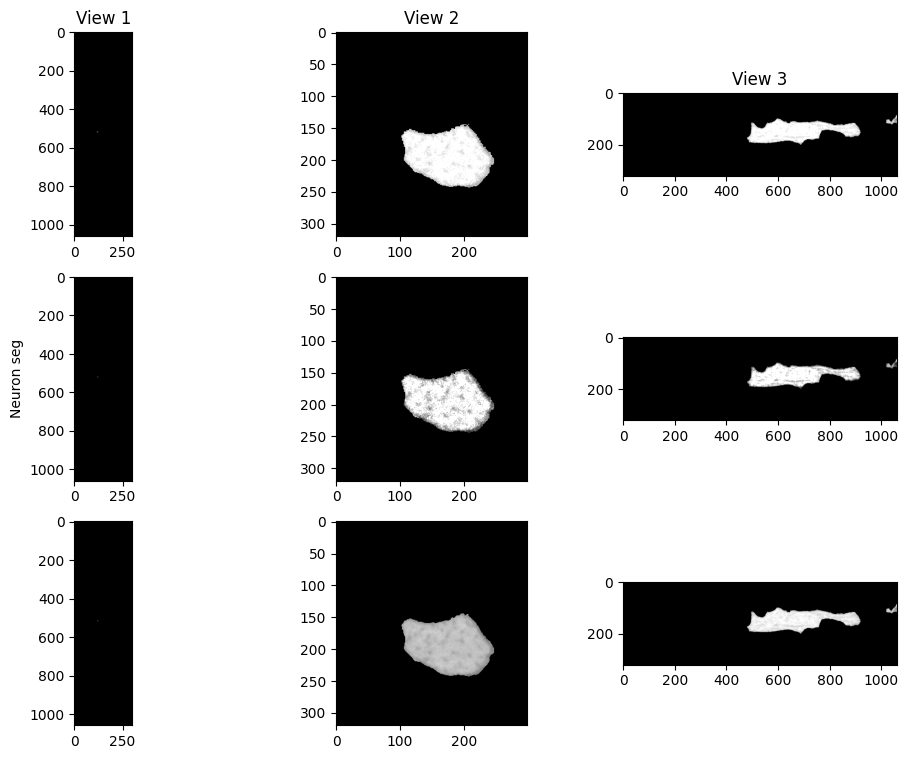

In [15]:
from skimage import exposure

for i in range(len(mito_seg)):
    print(sample_df.iloc[i].bodyId, sample_df.iloc[i].coord)
    sample_seg = mito_seg[i]
    sample_skel_subvol = skel_subvol[i]
    sample_gray_subvol = gray_subvol[i]
    sample_gray_subvol = np.where(sample_skel_subvol, sample_gray_subvol, 0)
    sample_gray_subvol_clahe = gray_subvol_clahe[i]
    sample_gray_subvol_clahe = np.where(sample_skel_subvol, sample_gray_subvol_clahe, 0)

    # sample_seg = sample_skel_subvol & sample_seg
    # print(sample_seg.any())

    gray_min, gray_max = np.quantile(sample_gray_subvol.flatten(), [0.01, 0.96])
    
    fig, axes = plt.subplots( figsize=(12,9) , ncols = 3, nrows = 3)

    axes[0,0].imshow(sample_gray_subvol[50,:,:], vmin=gray_min, vmax=gray_max, cmap = 'gray')
    axes[0,1].imshow(sample_gray_subvol[:,50,:], vmin=gray_min, vmax=gray_max, cmap = 'gray')
    axes[0,2].imshow(sample_gray_subvol[:,:,50], vmin=gray_min, vmax=gray_max, cmap = 'gray')

    axes[1,0].set_ylabel('Grayscale image')
    gray_min, gray_max = np.quantile(sample_gray_subvol_clahe.flatten(), [0.01, 0.96])
    
    axes[1,0].imshow(sample_gray_subvol_clahe[50,:,:], vmin=gray_min, vmax=gray_max, cmap = 'gray')
    axes[1,1].imshow(sample_gray_subvol_clahe[:,50,:], vmin=gray_min, vmax=gray_max, cmap = 'gray')
    axes[1,2].imshow(sample_gray_subvol_clahe[:,:,50], vmin=gray_min, vmax=gray_max, cmap = 'gray')
    
    axes[1,0].set_ylabel('Mito seg')

    # # Apply contrast stretching to improve visibility of faint structures
    # min_val, max_val = np.min(sample_gray_subvol[sample_skel_subvol]), np.max(sample_gray_subvol[sample_skel_subvol])
    # adjusted_min_val = min_val + (max_val - min_val) * 0.15
    # adjusted_max_val = max_val - (max_val - min_val) * 0.15
    
    # processed_data = np.copy(sample_gray_subvol)
    # processed_data[sample_skel_subvol] = exposure.rescale_intensity(
    #     sample_gray_subvol[sample_skel_subvol], 
    #     in_range=(adjusted_min_val, adjusted_max_val), 
    #     out_range=(0, 255)
    # )

    smoothed_image = filters.median(sample_gray_subvol)


    # enhanced_image = exposure.rescale_intensity(sample_gray_subvol, in_range=(min_val, max_val), out_range='dtype')
    axes[2,1].imshow(smoothed_image[:,50,:], vmin=0, vmax=255, cmap = 'gray')
    axes[2,0].imshow(smoothed_image[50,:,:], vmin=gray_min, vmax=gray_max, cmap = 'gray')
    axes[2,2].imshow(smoothed_image[:,:,50], vmin=gray_min, vmax=gray_max, cmap = 'gray')

    axes[1,0].set_ylabel('Neuron seg')
    
    fontsize=12
    axes[0,0].set_title('View 1', fontsize=fontsize)
    axes[0,1].set_title('View 2', fontsize=fontsize)
    axes[0,2].set_title('View 3', fontsize=fontsize)
    
    plt.show()

    break



In [72]:
import numpy as np
from skimage import filters
from skimage import io

# Assuming your 3D numpy array is named 'sample_gray_subvol'
# Apply the Frangi filter only to the non-zero regions
# frangi_output = filters.frangi(sample_gray_subvol[:, :20, :], sigmas=[1, 2, 3], scale_range=(1, 10), scale_step=2)
# frangi_output = filters.frangi(sample_gray_subvol[:, :20, :], sigmas=[2, 3, 4], scale_range=(2, 10), scale_step=2)
frangi_output = filters.sato(sample_gray_subvol[:, :50, :], sigmas=[2, 3, 4])

# The output will enhance the vessel-like structures within the neuron
# Ensure the outside area remains 0
frangi_output[sample_gray_subvol[:, :50, :] == 0] = 0






In [73]:
import nibabel as nib  # for NIFTI format


In [74]:
normalized = (frangi_output - frangi_output.min()) / (frangi_output.max() - frangi_output.min())
uint16_data = (normalized * 65535).astype(np.uint16)

nifti_img = nib.Nifti1Image(uint16_data, affine=np.eye(4))
nib.save(nifti_img, 'frangi_output.nii.gz')

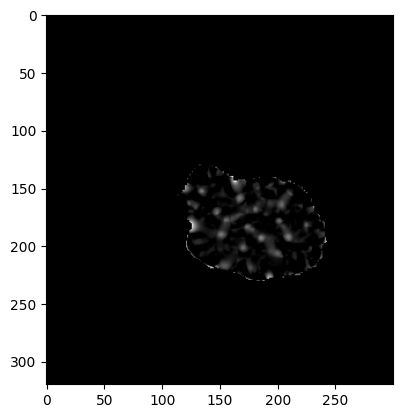

In [58]:
slice_index = 50  # Adjust as needed
plt.imshow(frangi_output[:,6,:], cmap='gray')
plt.show()

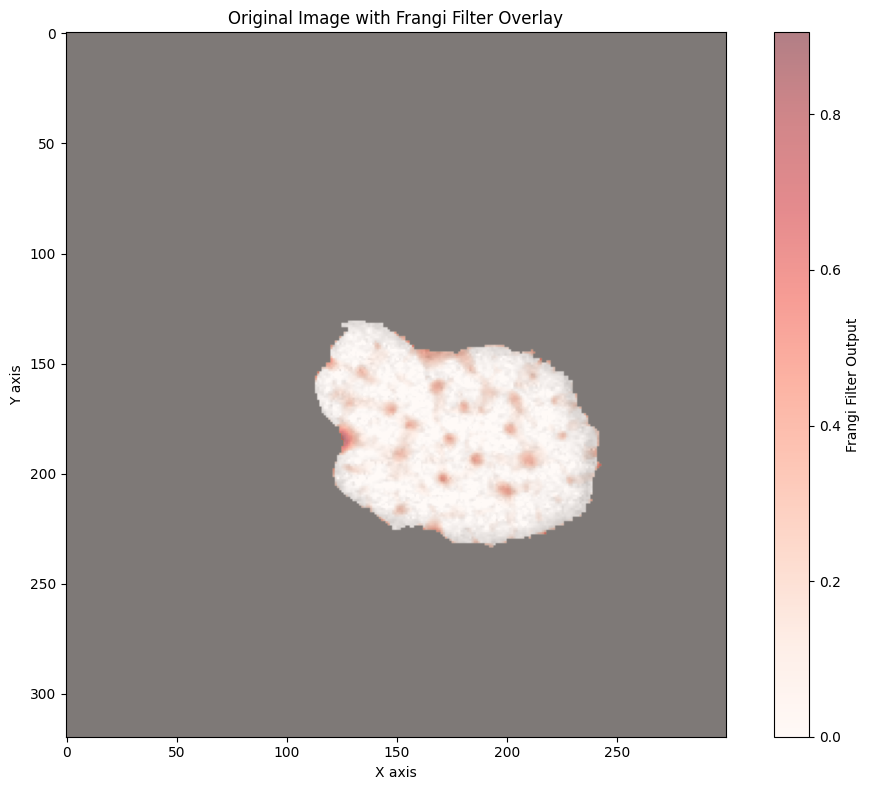

In [75]:
frangi_normalized = (frangi_output - frangi_output.min()) / (frangi_output.max() - frangi_output.min())

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Display the original grayscale image
ax.imshow(sample_gray_subvol[:,10,:], cmap='gray', vmin=gray_min, vmax=gray_max)

# Overlay the Frangi filter output
# We'll use a red colormap for the segmentation
segmentation = ax.imshow(frangi_normalized[:,10,:], cmap='Reds', alpha=0.5)

# Add a colorbar for the segmentation
cbar = fig.colorbar(segmentation, ax=ax, label='Frangi Filter Output')

# Set title and labels
ax.set_title('Original Image with Frangi Filter Overlay')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')

# Show the plot
plt.tight_layout()
plt.show()

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import matplotlib.colors as colors

def create_frangi_interactive(sample_gray_subvol, frangi_output):
    # Normalize Frangi output to 0-1 range
    frangi_normalized = (frangi_output - frangi_output.min()) / (frangi_output.max() - frangi_output.min())
    
    # Calculate global min and max for consistent colormap scaling
    # gray_min, gray_max = np.min(sample_gray_subvol[sample_skel_subvol]), np.max(sample_gray_subvol[sample_skel_subvol])
    gray_min, gray_max = np.quantile(sample_gray_subvol[sample_skel_subvol].flatten(), [0.1, 0.99])

    # Create a custom colormap that's transparent for low values
    cmap = plt.get_cmap('Reds').copy()
    cmap.set_under('none')  # Set color for values below vmin

    # Create an output widget to capture the plot
    out = widgets.Output()

    # Function to update the plot
    def update_plot(frame):
        with out:
            out.clear_output(wait=True)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
            
            # Plot original with Frangi filter overlay (left)
            ax1.imshow(sample_gray_subvol[:, frame, :], cmap='gray', vmin=gray_min, vmax=gray_max)
            ax1.imshow(frangi_normalized[:, frame, :], cmap=cmap, alpha=0.8, 
                       norm=colors.Normalize(vmin=0.25, vmax=1))
            ax1.set_title(f'Slice {frame}: Original with Frangi Filter Overlay')
            ax1.set_xlabel('X axis')
            ax1.set_ylabel('Z axis')
            
            # Plot original grayscale image (right)
            ax2.imshow(sample_gray_subvol[:, frame, :], cmap='gray', vmin=gray_min, vmax=gray_max)
            ax2.set_title(f'Slice {frame}: Original Image')
            ax2.set_xlabel('X axis')
            ax2.set_ylabel('Z axis')
            
            plt.tight_layout()
            plt.show()

    # Create a slider widget
    slider = widgets.IntSlider(
        value=0,
        min=0,
        max=frangi_output.shape[1] - 1,
        step=1,
        description='Slice:',
        continuous_update=True
    )

    # Link the slider to the update function
    widgets.interactive(update_plot, frame=slider)

    # Display the output and the slider
    display(widgets.VBox([slider, out]))
    
    # Initial plot
    update_plot(0)

# Usage example:
create_frangi_interactive(sample_gray_subvol, frangi_output)

In [56]:
np.save('test.npy', sample_gray_subvol_clahe)

In [10]:
for i in range(len(mito_seg)):
    sample_seg = mito_seg[i]
    sample_skel_subvol = skel_subvol[i]
    sample_gray_subvol = gray_subvol[i]
    sample_gray_subvol = np.where(sample_skel_subvol, sample_gray_subvol, 0)
    sample_gray_subvol = np.where(sample_seg, 0, sample_gray_subvol)

    # sample_seg = sample_skel_subvol & sample_seg
    print(sample_seg.any())

    gray_min, gray_max = np.quantile(sample_gray_subvol.flatten(), [0.01, 0.95])
    
    fig, axes = plt.subplots( figsize=(8,8) , ncols = 3, nrows = 3)

    axes[0,0].imshow(sample_gray_subvol[50,:,:], vmin=gray_min, vmax=gray_max, cmap = 'gray')
    axes[0,1].imshow(sample_gray_subvol[:,50,:], vmin=gray_min, vmax=gray_max, cmap = 'gray')
    axes[0,2].imshow(sample_gray_subvol[:,:,50], vmin=gray_min, vmax=gray_max, cmap = 'gray')

    axes[1,0].set_ylabel('Grayscale image')
    
    axes[1,0].imshow(sample_seg[50,:,:], vmin=0, vmax=1, cmap = 'gray')
    axes[1,1].imshow(sample_seg[:,50,:], vmin=0, vmax=1, cmap = 'gray')
    axes[1,2].imshow(sample_seg[:,:,50], vmin=0, vmax=1, cmap = 'gray')
    
    axes[1,0].set_ylabel('Mito seg')

    axes[2,0].imshow(sample_skel_subvol[50,:,:], vmin=0, vmax=1, cmap = 'gray')
    axes[2,1].imshow(sample_skel_subvol[:,50,:], vmin=0, vmax=1, cmap = 'gray')
    axes[2,2].imshow(sample_skel_subvol[:,:,50], vmin=0, vmax=1, cmap = 'gray')

    axes[1,0].set_ylabel('Neuron seg')
    
    fontsize=12
    axes[0,0].set_title('View 1', fontsize=fontsize)
    axes[0,1].set_title('View 2', fontsize=fontsize)
    axes[0,2].set_title('View 3', fontsize=fontsize)
    
    plt.show()

NameError: name 'mito_seg' is not defined

In [72]:
sample_seg = mito_seg[25]
sample_gray_subvol = gray_subvol[25]

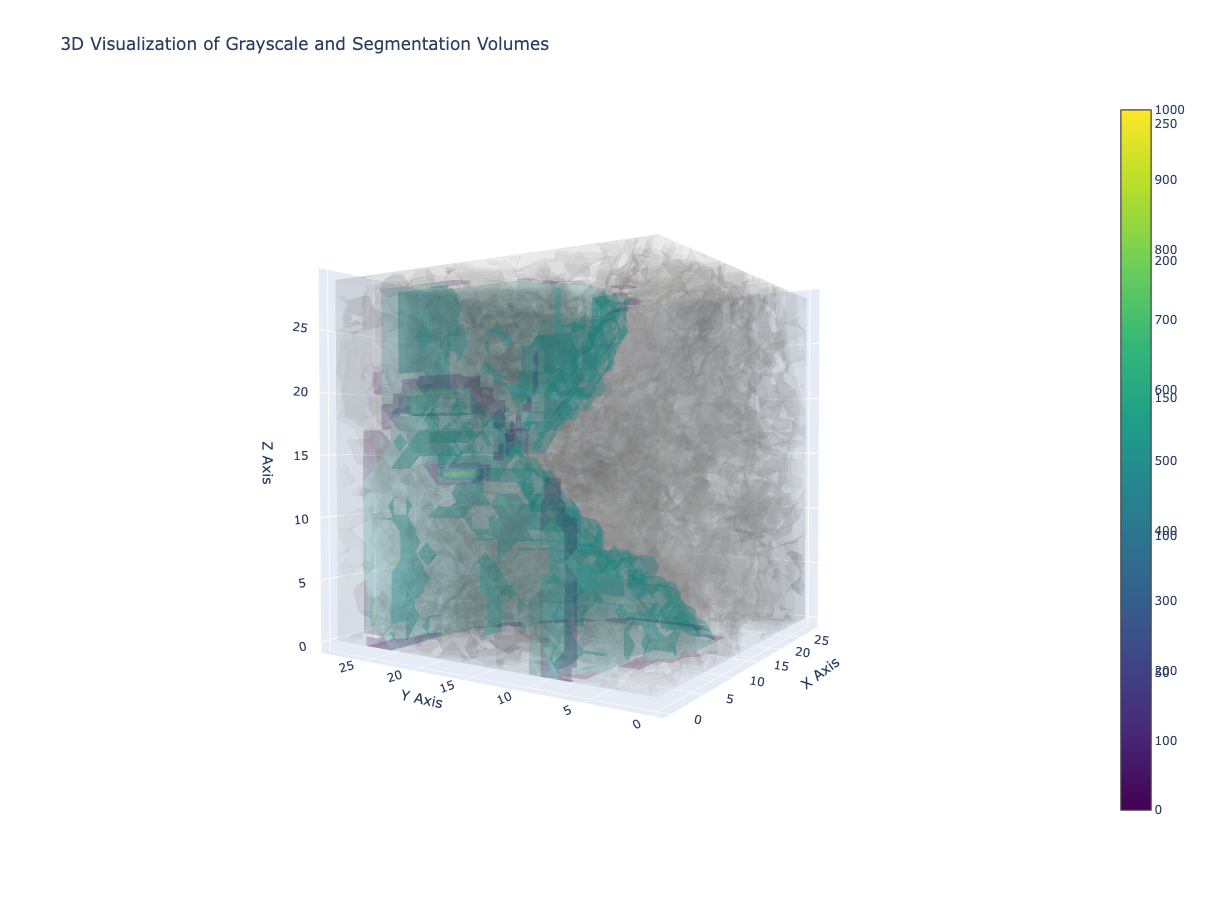

In [80]:
import numpy as np
import plotly.graph_objects as go
from scipy.ndimage import zoom
import plotly.io as pio
pio.renderers.default = "jupyterlab"

# Creating synthetic data for sample_gray_subvol and sample_seg
np.random.seed(42)
sample_seg = mito_seg[27]
sample_gray_subvol = gray_subvol[27]

# Downsampling data for visualization purposes
downsample_factor = 0.3  # To make it 10x10x10 for visualization
sample_gray_subvol_downsampled = zoom(sample_gray_subvol, downsample_factor)
sample_seg_downsampled = zoom(sample_seg, downsample_factor)

# Creating a figure
fig = go.Figure()

# Adding the grayscale volume
fig.add_trace(go.Volume(
    x=np.repeat(np.arange(sample_gray_subvol_downsampled.shape[0]), sample_gray_subvol_downsampled.shape[1]*sample_gray_subvol_downsampled.shape[2]),
    y=np.tile(np.repeat(np.arange(sample_gray_subvol_downsampled.shape[1]), sample_gray_subvol_downsampled.shape[2]), sample_gray_subvol_downsampled.shape[0]),
    z=np.tile(np.arange(sample_gray_subvol_downsampled.shape[2]), sample_gray_subvol_downsampled.shape[0]*sample_gray_subvol_downsampled.shape[1]),
    value=sample_gray_subvol_downsampled.flatten(),
    opacity=0.1,
    isomin=0,
    isomax=255,
    colorscale='Gray',
    surface_count=10,  # Number of isosurfaces
))

# Adding the segmentation volume
fig.add_trace(go.Volume(
    x=np.repeat(np.arange(sample_seg_downsampled.shape[0]), sample_seg_downsampled.shape[1]*sample_seg_downsampled.shape[2]),
    y=np.tile(np.repeat(np.arange(sample_seg_downsampled.shape[1]), sample_seg_downsampled.shape[2]), sample_seg_downsampled.shape[0]),
    z=np.tile(np.arange(sample_seg_downsampled.shape[2]), sample_seg_downsampled.shape[0]*sample_seg_downsampled.shape[1]),
    value=sample_seg_downsampled.flatten(),
    opacity=0.2,
    isomin=1,
    isomax=1000,
    colorscale='Viridis',
    surface_count=1,  # Single isosurface for binary segmentation
))

# Updating layout for better visualization
fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    title='3D Visualization of Grayscale and Segmentation Volumes'
)
fig.update_layout(
        width=1200,
        height=900,
)

# Displaying the plot
fig.show()
# pio.show(fig, renderer='iframe')